# Držík: Klasifikácia zdravia ľudského plodu na základe údajov CTG

## 0. Import knižníc 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

from keras.utils import np_utils
from keras.utils import to_categorical #prepis do kategorickej premennej

from keras.models import Sequential #import sekvenčného modelu 
from keras.layers import Dense

## 1. Preskúmanie datasetu 

In [2]:
# Načítame si csv súbor pomocou knižnice pandas do premennej data
# Zdrojový dataset (v .csv) už obsahuje header, 
# preto nemusíme pri načítavaní nič prispôsobovať, iba musíme nastaviť separátor na "," 
data = pd.read_csv("fetal_health.csv", sep=",")

In [3]:
# Obsah premennej data si necháme vypísať. Zistíme, že dataset obsahuje 2126 riadkov (záznamov) a 22 stĺpcov
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [4]:
# Zobrazíme si pomocou metódy info() dátové typy jednotlivých stĺpcov a počet nenulových hodnôt jednotlivých stĺpcov
data.info()
# Zistili sme, že v našom datasete máme všetky hodnoty nenulové a všetky hodnoty sú číselného typu float64.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [5]:
# Metódou describe() dostaneme základný štatistický prehľad o našom datasete (v transponovanom tvare)
data.describe().T
# Už tu môžeme vidieť, že rozpätie hodnôt je veľmi vysoké. Pre príklad parameter "accelerations" má minimálnu hodnotu 0.0
# a maximálnu hodnotu 0.019 a parameter "abnormal_short_term_variability" má minimum 12.0 a maximum 87.
# Údaje sú príliž rôznorodé, bude ich treba znormalizovať (zoškálovať).

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


Dátový súbor obsahuje dáta z  kardiotokogramu (CTG), na základe ktorých sa dá jednoducho posúdiť zdravie ľudského plodu. Samotné zariadenie funguje tak, že vysiela ultrazvukové impulzy a číta jeho odozvu, čím získava tepovú frekvenciu srdca, pohyby plodu, kontrakcie maternice a ďalšie. Odborníci na základe jednotlivých dát zaklasifikovali zdravie plodu. Určili 3 triedy (fetal_health):
- <b>Normal</b> = označený ako 1 v datasete, klasifikovaný ako zdravý
- <b>Suspect</b> = označený ako 2 v datasete, klasifikovaný ako podozrivý
- <b>Pathological</b> = označený ako 3 v datasete, klasifikovaný ako nezdravý

<b>Získané charakteristiky z CTG:</b>

- '<b>baseline value</b>' = Tepová frekvencia srdca plodu za minútu
- '<b>accelerations</b>' = Zrýchlenie (zvýšenie srdcovej frekvencie) za sekundu
- '<b>fetal_movement</b>' = Počet pohybov plodu za sekundu
- '<b>uterine_contractions</b>' = Počet kontrakcií maternice za sekundu
- '<b>light_decelerations</b>' = Počet miernych spomalení tepovej frekvencie za sekundu 
- '<b>severe_decelerations</b>' = Počet prudkých spomalení tepovej frekvencie za sekundu
- '<b>prolongued_decelerations</b>' = Počet dlho trvajúcich spomalení tepovej frekvencie za sekundu
- '<b>abnormal_short_term_variability</b>' = Percento času s abnormálnou krátkodobou variabilitou
- '<b>mean_value_of_short_term_variability</b>' = Priemerná hodnota krátkodobej variability
- '<b>percentage_of_time_with_abnormal_long_term_variability</b>' = Percento času s abnormálnou dlhodobou variabilitou
- '<b>mean_value_of_long_term_variability</b>' = Priemerná hodnota dlhodobej variability
- '<b>histogram_width</b>' = Šírka histogramu tepovej frekvencie plodu
- '<b>histogram_min</b>' = Minimum (najnižšia frekvencia) z histogramu tepovej frekvencie plodu
- '<b>histogram_max</b>' = Maximum (najvyššia frekvencia) z histogramu tepovej frekvencie plodu
- '<b>histogram_number_of_peaks</b>' = Počet maximálnych hodnôt histogramu
- '<b>histogram_number_of_zeroes</b>' = Počet minimálnych hodnôt histogramu
- '<b>histogram_mode</b>' = Modus histogramu
- '<b>histogram_mean</b>' = Priemer histogramu
- '<b>histogram_median</b>' = Medián histogramu
- '<b>histogram_variance</b>' = Rozptyl histogramu
- '<b>histogram_tendency</b>' = Tendencia histogramu

<b>Výsledný zdravotný stav plodu na základe údajov z CTG:</b>

- '<b>fetal_health</b>' Normal (1), Suspect (2) a Pathological (3)

Zdroj: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6822315/

## 2. Analýza dát  

      Normal (1): 1655
     Suspect (2): 295
Pathological (3): 176
___________________________
           Spolu: 2126


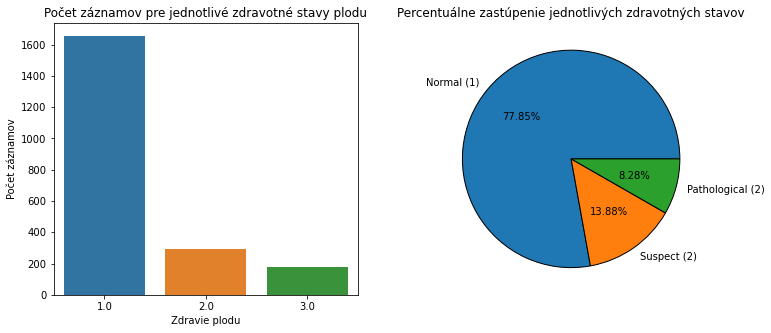

In [6]:
plt.figure(figsize = (12,5))
plt.subplot(121)
sns.countplot(x="fetal_health", data=data)

plt.title("Počet záznamov pre jednotlivé zdravotné stavy plodu")
plt.xlabel("Zdravie plodu")
plt.ylabel("Počet záznamov")

plt.subplot(122)
normal = data[data['fetal_health'] == 1].count()[0]
suspect = data[data['fetal_health'] == 2].count()[0]
pathological = data[data['fetal_health'] == 3].count()[0]
plt.pie([normal, suspect, pathological], labels=["Normal (1)", "Suspect (2)", "Pathological (2)"], autopct="%1.2f%%",wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})

plt.title("Percentuálne zastúpenie jednotlivých zdravotných stavov") 

print("      Normal (1):",normal)
print("     Suspect (2):",suspect)
print("Pathological (3):",pathological)
print("___________________________")
print("           Spolu:",normal + suspect + pathological)

V jednom aj v druhom grafe je vidieť, že výsledné zdravotné stavy nie sú v datasete rovnomerne zastúpené. Konkrétne 75.85% záznamov bolo kategorizovaných ako zdravotný stav Normal (1), 13.88% ako zdravotný stav Suspect (2) a najmenej bolo kategorizovaných do zdravotného stavu Pathological (3), presne 8.28%.

Text(0.5, 1.0, 'Tepová frekvencia plodu pre každý zdravotný stav')

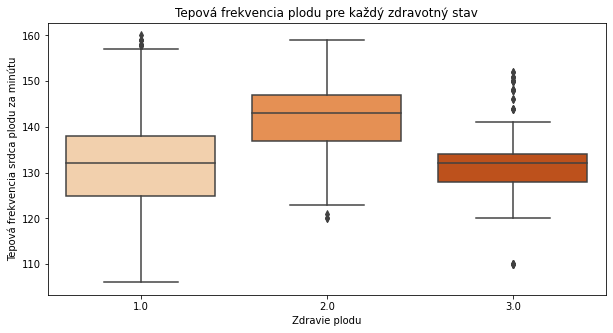

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x = data['fetal_health'], y = data['baseline value'], data = data, palette="Oranges")
plt.xlabel("Zdravie plodu")
plt.ylabel("Tepová frekvencia srdca plodu za minútu")
plt.title("Tepová frekvencia plodu pre každý zdravotný stav")

<AxesSubplot:>

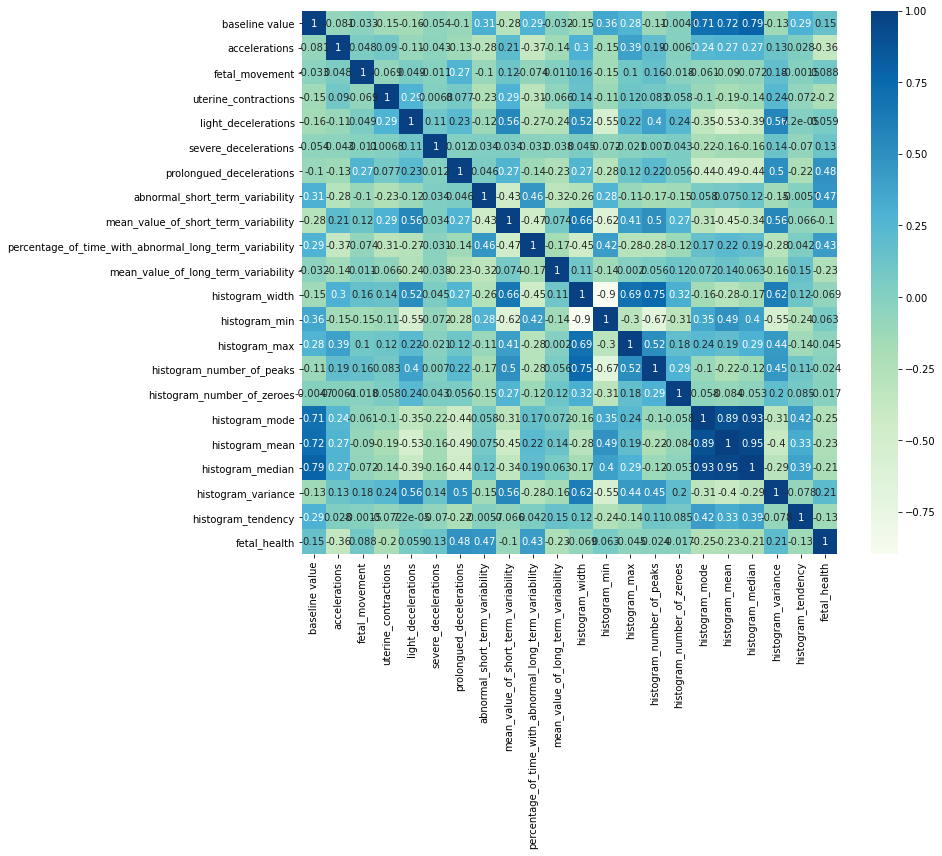

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap = "GnBu")  

#Na základe korelácie, ktorú sme zobrazili v teplotnej mape môžeme povedať, že najviac budú výsledok (fetal_health)
# ovplyvňovať parametre prolongued_decelerations, abnormal_short_term_variability a percentage_of_time_with_abnormal_long_term_variability
# Avšak ani korelácia týchto paramterov nie je dostatočne vysoká.

## 3. Predspracovanie dát 

### a) Normalizácia a prepis do kategorickej premennej 

Na základe príkazu <b>data.describe().T</b> sme zistili, že dáta sú príliš rôznorodé a musíme ich znormalizovať. Po znormalizovaní budú všetky dáta zoškálované do jednotného intervalu, pričom sa zachová rozsah ich hodnôt. Škálovať dáta budeme prostredníctvom triedy <b>sklearn.preprocessing.StandardScaler</b> a použijeme metódu <b>fit_transform</b>, ktorá bude obsahovať parameter našich vstupných dát, ktoré chceme znormalizovať.

In [9]:
# Do premennej X_vstup vložíme všetky dáta od 0 do 20 (vrátane) stĺpca, pretože to sú práve všetky charakteristiky z CTG.
X_vstup = data.iloc[:,0:21].values

# Do premennej Y_vystup vložíme všetky dáta posledného (21.) stĺpca, čo predstavuje práve zdravotný stav plodu.
Y_vystup = data.iloc[:,21].values

# Škálujeme dáta a výsledok uložíme do premennej X.
standard_scaler = StandardScaler()
X =  standard_scaler.fit_transform(X_vstup)

#Hodnoty 1.0, 2.0 a 3.0 prevedieme na binárnu kategorickú premennú pomocou knižnice keras a pomocou metódy 
# np_utils.to_categorical, ktorej parametrom je práve Y_vystup.
Y = np_utils.to_categorical(Y_vystup)
# Keďže naše hodnoty sú indeované od 1 a nie od 0 a práve táto metóda od keras očakáva indexovanie od nuly, musíme
# prvý stĺpec odstrániť, keďže bol vo výsledku zahrnutý.
Y = Y[:,[1,2,3]]

In [10]:
# Zobrazíme si zoškálované dáta v prehľadnej forme
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.352220,-0.822388,-0.203210,-1.482465,-0.638438,-0.057476,-0.268754,1.513190,-0.943095,1.802542,...,-0.165507,-1.068562,-2.119592,-0.701397,-0.458444,-1.065614,0.153270,-1.181642,1.870569,1.112980
1,-0.132526,0.730133,-0.203210,0.554627,0.375243,-0.057476,-0.268754,-1.744751,0.868841,-0.535361,...,1.529124,-0.865539,1.893794,0.655137,0.958201,0.216638,0.089126,0.132038,-0.234998,-0.524526
2,-0.030884,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,0.868841,-0.535361,...,1.529124,-0.865539,1.893794,0.316003,0.958201,0.216638,0.024982,-0.006244,-0.200481,-0.524526
3,0.070757,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,...,1.195333,-1.373097,0.333033,2.350804,-0.458444,-0.027600,-0.039162,-0.075385,-0.200481,1.112980
4,-0.132526,0.988886,-0.203210,1.233657,-0.638438,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,...,1.195333,-1.373097,0.333033,1.672537,-0.458444,-0.027600,0.089126,-0.006244,-0.269516,1.112980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,0.680604,-0.822388,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.282833,0.823885,...,-0.781736,1.469229,0.723223,-0.023130,-0.458444,0.949354,0.987141,0.961731,-0.580173,-0.524526
2122,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.660775,...,-0.114154,0.318764,0.277292,0.655137,-0.458444,0.888294,0.858853,0.892590,-0.545656,1.112980
2123,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.056341,0.552035,...,-0.088478,0.318764,0.333033,0.316003,-0.458444,0.949354,0.858853,0.961731,-0.511138,1.112980
2124,0.680604,-0.563635,-0.203210,0.554627,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.932624,...,-0.114154,0.318764,0.277292,0.655137,-0.458444,0.888294,0.794709,0.892590,-0.511138,1.112980


In [11]:
print("Pred: ",Y_vystup[0:5])
print("Po: ")
print(Y[0:5])

# Výstupné dáta (prvých 5) si zobrazíme najskôr pred prevedením do binárnej kategorickej premennej. Potom si ich zobrazíme
# po prevedení do binárnej kategorickej premennej. Vidíme, že ak bol zdravotný stav označený ako 2.0, tak v kategorickej
# sa z toho stalo pole [0,1,0], pričom jediná jednotka je práve na druhom mieste. Analogicky ďaľšie štyri jednotky
# sú zobrazené na prvom mieste.

Pred:  [2. 1. 1. 1. 1.]
Po: 
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Na základe korelácie, ktorú sme vykonali v predchádzajucej časti v analýze dát môžeme vizualizovať znormalizované parametre prolongued_decelerations, abnormal_short_term_variability a percentage_of_time_with_abnormal_long_term_variability pre všetky zdravotné stavy (fetal_health).

In [12]:
df = pd.DataFrame(X,Y_vystup)
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'fetal_health'})

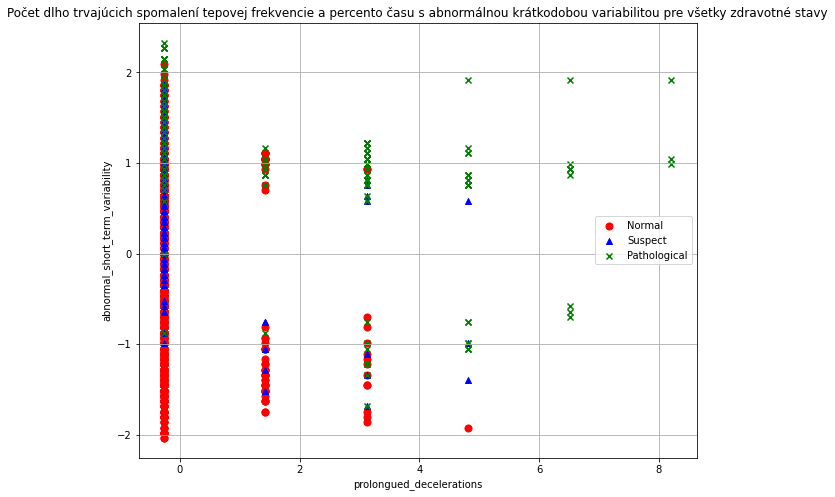

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(df.loc[df['fetal_health'] == 1.0][6], df.loc[df['fetal_health'] == 1.0][7], color = 'red', label = 'Normal', s=50)
plt.scatter(df.loc[df['fetal_health'] == 2.0][6], df.loc[df['fetal_health'] == 2.0][7], color = 'blue', label = 'Suspect', marker = '^')
plt.scatter(df.loc[df['fetal_health'] == 3.0][6], df.loc[df['fetal_health'] == 3.0][7], color = 'green', label = 'Pathological', marker = 'x')

plt.xlabel('prolongued_decelerations')
plt.ylabel('abnormal_short_term_variability')
plt.legend(loc="center right")
plt.title('Počet dlho trvajúcich spomalení tepovej frekvencie a percento času s abnormálnou krátkodobou variabilitou pre všetky zdravotné stavy')
plt.grid(b=True, which='major', color='#aaaaaa', linestyle='-')
plt.show()

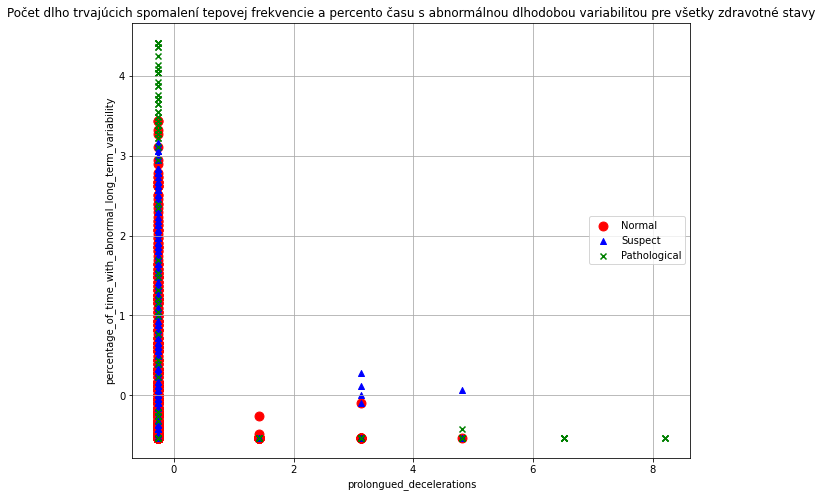

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(df.loc[df['fetal_health'] == 1.0][6], df.loc[df['fetal_health'] == 1.0][9], color = 'red', label = 'Normal', s=80)
plt.scatter(df.loc[df['fetal_health'] == 2.0][6], df.loc[df['fetal_health'] == 2.0][9], color = 'blue', label = 'Suspect', marker = '^')
plt.scatter(df.loc[df['fetal_health'] == 3.0][6], df.loc[df['fetal_health'] == 3.0][9], color = 'green', label = 'Pathological', marker = 'x')

plt.xlabel('prolongued_decelerations')
plt.ylabel('percentage_of_time_with_abnormal_long_term_variability')
plt.legend(loc="center right")
plt.title('Počet dlho trvajúcich spomalení tepovej frekvencie a percento času s abnormálnou dlhodobou variabilitou pre všetky zdravotné stavy')
plt.grid(b=True, which='major', color='#aaaaaa', linestyle='-')
plt.show()

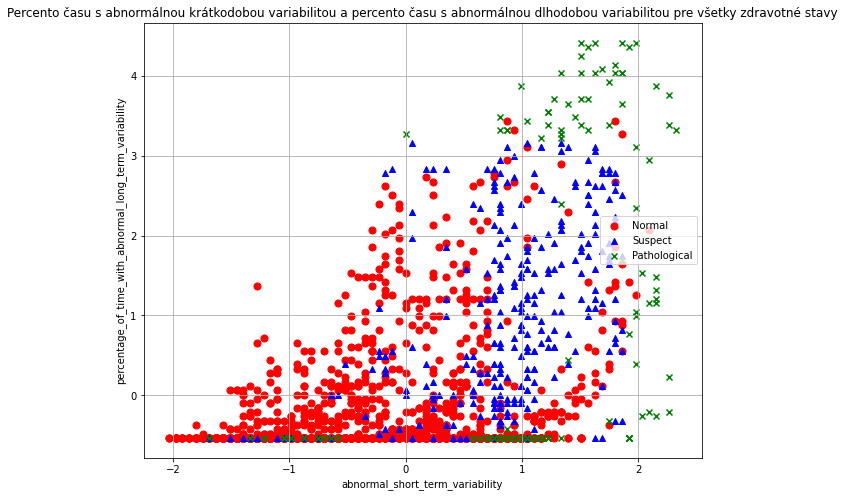

In [15]:
plt.figure(figsize=(10,8))
plt.scatter(df.loc[df['fetal_health'] == 1.0][7], df.loc[df['fetal_health'] == 1.0][9], color = 'red', label = 'Normal', s=50)
plt.scatter(df.loc[df['fetal_health'] == 2.0][7], df.loc[df['fetal_health'] == 2.0][9], color = 'blue', label = 'Suspect', marker = '^')
plt.scatter(df.loc[df['fetal_health'] == 3.0][7], df.loc[df['fetal_health'] == 3.0][9], color = 'green', label = 'Pathological', marker = 'x')

plt.xlabel('abnormal_short_term_variability')
plt.ylabel('percentage_of_time_with_abnormal_long_term_variability')
plt.legend(loc="center right")
plt.title('Percento času s abnormálnou krátkodobou variabilitou a percento času s abnormálnou dlhodobou variabilitou pre všetky zdravotné stavy')
plt.grid(b=True, which='major', color='#aaaaaa', linestyle='-')
plt.show()

### b) Rozdelenie dát na trénovacie a testovacie 

Veľmi dôležitou časťou je rozdelenie dát do trénovacích a testovacích množín alebo inak povedané na trénovacie a testovacie dáta. Na natrénovanie (naučenie) neurónovej siete použijeme trénovacie dáta a na overenie správnosti klasifikácie neurónovej siete (správnosti jej natrénovania) použijeme zase testovacie dáta.

In [16]:
#Na rozdelenie dát do trenovacích a testovacích množín použijeme metódu train_test_split z knižnice sklearn.model_selection
# Vstupom tejto metódy je zoškálovaná matica vstupov (X), matica výstupov v binárnej kategorickej premennej (Y).
# Parametrom train_size určíme v akom pomere chceme trénovacie a testovacie dáta rozdeliť. Najčastejšie sa delia
# v pomeroch 70:30 alebo 80:20. My sme si vybrali pomer 80:20 a zapísali sme ho ako "train_size = 0.8".

#Ďalším parametrom je random_state, ktorý ešte pred rozdelením dát premieša jednotlivé záznamy na základe stanoveného stavu
# (to je to číslo 42, mohlo by byť samozrejme aj iné, ale odporúča sa používať stále to isté, aby pri každom spustení
# tento algoritmus pomiešal dáta úplne rovnako). A parameter stratify = Y zachová podiel Y v rozdelených množinách.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 42, stratify = Y)

# Vstupné dáta X sa rozdelia v pomere 80:20 do premenných X_train a X_test v "náhodnom" poradí.
# Výstupné dáta Y sa rozdelia v pomere 80:20 do premenných Y_train a Y_test v "náhodnom" poradí.

In [17]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
# Počet riadkov a stĺpcov po rozdelení je nasledovný. Vidíme, že to skutočne rozdelilo v správnom pomere.

((1700, 21), (426, 21), (1700, 3), (426, 3))

Prvých 5 riadkov z každej matice je zobrazených nižšie:

In [18]:
pd.DataFrame(X_train).head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.578963,-0.822388,-0.053172,-1.482465,-0.638438,-0.057476,-0.268754,1.804078,-1.282833,2.672459,...,-1.526347,1.333880,-1.116245,-1.040530,-0.458444,0.155579,0.281558,0.201179,-0.649208,-0.524526
1,0.985528,-0.822388,-0.203210,-0.463919,-0.638438,-0.057476,-0.268754,1.164125,-1.169587,-0.209142,...,-1.192556,1.367717,-0.335865,-1.040530,-0.458444,0.399817,0.602278,0.546884,-0.614691,-0.524526
2,1.798657,-0.822388,-0.203210,0.554627,0.713136,-0.057476,-0.268754,0.582350,1.435070,0.334556,...,2.016973,-1.440771,2.005277,2.689937,10.874714,1.132532,0.987141,1.307436,1.283771,1.112980
3,0.985528,-0.046128,-0.053172,-1.482465,-0.300544,-0.057476,-0.268754,0.175107,-0.263619,-0.372252,...,1.426420,-0.662515,2.005277,1.333404,-0.458444,0.644055,0.794709,0.754307,-0.511138,-0.524526
4,0.070757,0.212626,0.482678,-0.124404,-0.300544,-0.057476,-0.268754,1.047770,1.095333,-0.535361,...,-0.935793,1.130857,-0.168640,-1.040530,-0.458444,0.033459,-0.359882,0.132038,-0.545656,-2.162031


In [19]:
pd.DataFrame(Y_train).head(5)

,0,1,2
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [20]:
pd.DataFrame(X_test).head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.030884,-0.822388,0.096866,-1.482465,-0.638438,-0.057476,-0.268754,1.455013,-1.169587,0.552035,...,-0.987146,0.724810,-0.949021,-0.701397,-0.458444,-0.271839,0.089126,-0.144526,-0.545656,-0.524526
1,0.985528,-0.822388,-0.203210,-1.142949,-0.638438,-0.057476,-0.268754,1.280480,-1.169587,-0.100403,...,-1.115527,1.300043,-0.280123,-1.040530,-0.458444,0.521936,0.666422,0.546884,-0.614691,-0.524526
2,-0.030884,-0.822388,-0.010304,-0.803434,-0.638438,-0.057476,-0.268754,0.407817,-0.829849,-0.535361,...,0.245313,-0.865539,-0.893279,-0.701397,-0.458444,-0.027600,0.217414,0.062897,-0.580173,1.112980
3,0.172398,0.988886,-0.160342,0.554627,-0.638438,-0.057476,-0.268754,0.756882,-0.376865,-0.535361,...,-0.781736,0.995508,-0.057157,-1.379664,-0.458444,0.644055,0.473990,0.477743,-0.407586,-0.524526
4,0.985528,-0.822388,-0.203210,-0.463919,-0.638438,-0.057476,-0.268754,0.989593,-0.829849,0.878254,...,0.373694,-0.696353,-0.335865,0.994270,0.958201,0.521936,0.666422,0.616025,-0.580173,1.112980


In [21]:
pd.DataFrame(Y_test).head(5)

,0,1,2
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


## 4. Neurónová sieť - knižnica Keras 

Na klasifikovanie zdravia plodu som si vybral sekvenčný model neurónovej siete knižnice Keras. Knižnica Keras obsahuje množstvo implementácií bežne používaných stavebných blokov neurónových sietí, ako sú vrstvy, stratové a chybové funkcie, aktivačné funkcie, optimalizátory a množstvo ďalších nástrojov na zjednodušenie zápisu neurónových sietí.

### a) Vytvorenie modelu neurónovej siete 

In [22]:
# Príkazom Sequential() si inicializujeme túto triedu. Odteraz budeme pracovať s premennou keras_model.
keras_model = Sequential()

# Metódou add() pridáme modelu neurónovej siete vrstvu (konkrétne Dense). V našom modeli budeme mať konkrétne 3 vrstvy.
# Z toho posledná vrstva je výstupnou vrstvou a prvé dve sú skryté vrstvy.

# Zadáme vstupné parametre Dense metódy, kde prvým parametrom bude počet neurónov (určíme si 15), 
# druhým parametrom input_dim = 21, 21 preto, lebo máme 21 vstupných parametrov,
# a tretím parametrom je aktivačná funkcia activation="relu". 
keras_model.add(Dense(15, input_dim=21, activation="relu", name="Skryta_vrstva_1"))

# Druhá vrstva bude mať 12 neurónov a aktivačná funkcia bude znova relu.
keras_model.add(Dense(12, activation="relu", name="Skryta_vrstva_2"))

# Tretia vrstva (výstupná) bude mať 3 neuróny, pretože máme 3 kategórie zdravia plodu (fetal_health)
# a aktivačná funkcia bude softmax, pretože sa používa ako aktivačná funkcia pri problémoch s klasifikáciou viacerých tried
# a my máme konkrétne 3 klasifikačné triedy.
keras_model.add(Dense(3, activation="softmax", name="Vystupna_vrstva"))

#Príkazom summary() si skontrolujeme nami vytvorený model.
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Skryta_vrstva_1 (Dense)      (None, 15)                330       
_________________________________________________________________
Skryta_vrstva_2 (Dense)      (None, 12)                192       
_________________________________________________________________
Vystupna_vrstva (Dense)      (None, 3)                 39        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Pre natrénovanie tohto modelu potrebujeme ešte zadefinovať stratovú funkciu, optimalizér a metriky.
# To urobíme prostredníctvom metódy compile, kde ako parametre vstupujú práve:
# - loss='categorical_crossentropy' = stratová funkcia vhodná vtedy, ak máme viac klasifikačných tried.
# - optimizer='adam' = Adam je vo väčšine prípadov najlepší z adaptívnych optimalizátorov.
# - metrics=['accuracy'] = a metriku sme nastavili na presnosť.

keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### b) Trénovanie modelu neurónovej siete 

In [24]:
# Po skompilovaní modelu nám stačí model našej neurónovej len natrénovať. Použijeme metódu fit a vstupnými parametrami
# budú vstupná trénovacia množina (X_train), výstupná trénovacia množina (Y_train),
# validačné dáta (X_test a Y_test) pomocou ktorých sa nám po jednotlivých krokoch počíta chybovosť a presnosť modelu.
# a posledným parametrom je počet iterácií (epochs), ktoré sme nstavili na 90.
keras_model_output = keras_model.fit(X_train, Y_train, validation_data = (X_test,Y_test), epochs=90)

Epoch 1/90
54/54 [==============================] - 1s 21ms/step - loss: 0.9566 - accuracy: 0.5826 - val_loss: 0.6751 - val_accuracy: 0.7934
Epoch 2/90
54/54 [==============================] - 0s 1ms/step - loss: 0.6354 - accuracy: 0.8043 - val_loss: 0.5054 - val_accuracy: 0.8333
Epoch 3/90
54/54 [==============================] - 0s 987us/step - loss: 0.4831 - accuracy: 0.8491 - val_loss: 0.4200 - val_accuracy: 0.8615
Epoch 4/90
54/54 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 0.8582 - val_loss: 0.3722 - val_accuracy: 0.8662
Epoch 5/90
54/54 [==============================] - 0s 1ms/step - loss: 0.3540 - accuracy: 0.8680 - val_loss: 0.3433 - val_accuracy: 0.8662
Epoch 6/90
54/54 [==============================] - 0s 1ms/step - loss: 0.3322 - accuracy: 0.8738 - val_loss: 0.3244 - val_accuracy: 0.8709
Epoch 7/90
54/54 [==============================] - 0s 1ms/step - loss: 0.3024 - accuracy: 0.8766 - val_loss: 0.3113 - val_accuracy: 0.8732
Epoch 8/90
54/54 

54/54 [==============================] - 0s 1ms/step - loss: 0.1271 - accuracy: 0.9436 - val_loss: 0.2629 - val_accuracy: 0.9343
Epoch 60/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.9416 - val_loss: 0.2674 - val_accuracy: 0.9249
Epoch 61/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1382 - accuracy: 0.9326 - val_loss: 0.2646 - val_accuracy: 0.9343
Epoch 62/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1211 - accuracy: 0.9550 - val_loss: 0.2649 - val_accuracy: 0.9343
Epoch 63/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1239 - accuracy: 0.9448 - val_loss: 0.2645 - val_accuracy: 0.9343
Epoch 64/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1373 - accuracy: 0.9334 - val_loss: 0.2668 - val_accuracy: 0.9319
Epoch 65/90
54/54 [==============================] - 0s 1ms/step - loss: 0.1275 - accuracy: 0.9385 - val_loss: 0.2661 - val_accuracy: 0.9319
Epoch 66/90
54/54 [======

Výsledok po natrénovaní modelu sa môže pri každom spustení líšiť, ale nie o veľa. Pri zvýšeom počte iterácií sa model zvykol "preučiť" a chybovosť modelu neklesala, ale naopak rástla. 

### c) Testovanie presnosti natrénovaného modelu 

In [25]:
# Pomocou metódy predict() dokážeme predpovedať výsledok vstupných testovacích dát (X_test).
# Výsledok uložíme po premennej Y_predikcia. Pre ukážku, takto vyzerá jeden predpovedaný stav: [0.32808095, 0.4721929 , 0.19972613]
# Môžeme vidieť, že s 47% pravdepodobnostou by bol zdravotný stav klasifikovaný ako Suspect (druhý stav).
Y_predikcia = keras_model.predict(X_test)

#Pomocou funkcie argmax prekonvertujeme predikované hodnoty z podoby [0.32808095, 0.4721929 , 0.19972613] na podobu "1.0",
# pričom bude do listu vložený iba index najviac predpovedanej predpovede. 0 pre Normal, 1 pre Suspect a 2 pre Pathological.
predikcie = list()
for i in range(len(Y_predikcia)):
    predikcie.append(np.argmax(Y_predikcia[i]))
    
# Rovnaký postup aplikujeme aj na výstupné testovacie dáta (Y_test), ktorú z podoby [0., 1., 0.] prekonvertujeme na "1.0",
# pričom bude do listu vložený index pozície jednotky. 
test = list()
for i in range(len(Y_test)):
    test.append(np.argmax(Y_test[i]))
    
# Teraz máme 2 množiny: predikované hodnoty na základe vstupných testovacích dát a výstupné testovacie hodnoty.

In [26]:
# Následne hodnoty z týchto dvoch množín porovnáme a vyhodnotíme na kolko percent sa výsledky zhodujú.
print("Presnosť (%):", accuracy_score(predikcie, test)*100)

Presnosť (%): 92.95774647887323


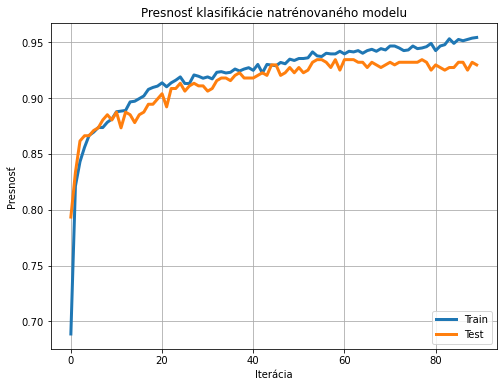

In [27]:
plt.figure(figsize=(8,6))
plt.plot(keras_model_output.history["accuracy"], linewidth=3)
plt.plot(keras_model_output.history["val_accuracy"], linewidth=3)
plt.title("Presnosť klasifikácie natrénovaného modelu")
plt.ylabel("Presnosť")
plt.xlabel("Iterácia")
plt.legend(["Train", "Test"], loc="lower right")
plt.grid(b=True, which='major', color='#aaaaaa', linestyle='-')
plt.show()

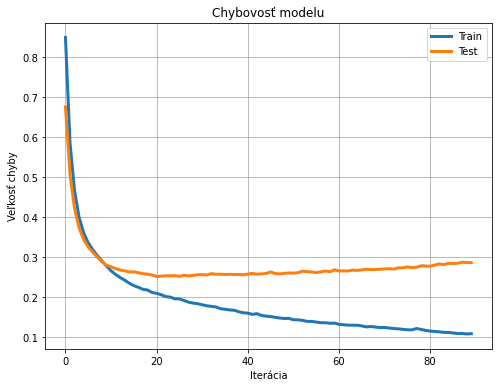

In [28]:
plt.figure(figsize=(8,6))
plt.plot(keras_model_output.history['loss'], linewidth=3)
plt.plot(keras_model_output.history['val_loss'], linewidth=3)
plt.title('Chybovosť modelu')
plt.ylabel('Veľkosť chyby')
plt.xlabel('Iterácia')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid(b=True, which='major', color='#aaaaaa', linestyle='-')
plt.show()

<AxesSubplot:>

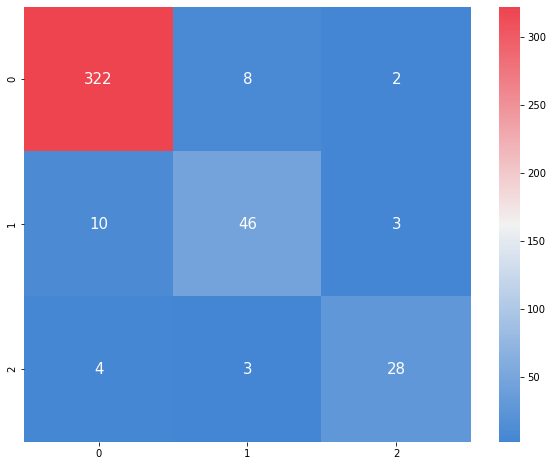

In [29]:
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
plt.subplots(figsize=(10,8))
cf_matrix = confusion_matrix(test, predikcie)
sns.heatmap(cf_matrix, cmap=cmap,annot = True, annot_kws = {'size':15}, fmt='g')

In [30]:
print(classification_report(test, predikcie))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       332
           1       0.81      0.78      0.79        59
           2       0.85      0.80      0.82        35

    accuracy                           0.93       426
   macro avg       0.87      0.85      0.86       426
weighted avg       0.93      0.93      0.93       426

